Project Description

Using a dataset comprised of songs of two music genres (Hip-Hop and Rock), you will train a classifier to distinguish between the two genres based only on track information derived from Echonest (now part of Spotify). You will first make use of pandas and seaborn packages in Python for subsetting the data, aggregating information, and creating plots when exploring the data for obvious trends or factors you should be aware of when doing machine learning. Next, you will use the scikit-learn package to predict whether you can correctly classify a song's genre based on features such as danceability, energy, acousticness, tempo, etc. You will go over implementations of common algorithms such as PCA, logistic regression, decision trees, and so forth.

In [1]:
import pandas as pd 
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from string import ascii_letters
import seaborn as sns

from collections import Counter, defaultdict

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_val_score, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, confusion_matrix, classification_report, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression

%matplotlib inline
plt.style.use('ggplot')

In [3]:
file_path = r"C:\Users\vicky\Downloads\dataset.csv\dataset.csv"

In [4]:
# Read in track metadata with genre labels
df = pd.read_csv(file_path)


C:\Users\vicky\AppData\Local\Temp\ipykernel_16996\3716717493.py:2: DtypeWarning: Columns (0,1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [5]:
df.head()

track_name            artists_name  \
0                      Comedy             Gen Hoshino   
1            Ghost - Acoustic            Ben Woodward   
2              To Begin Again  Ingrid Michaelson;ZAYN   
3  Can't Help Falling In Love            Kina Grannis   
4                     Hold On        Chord Overstreet   

                                          album_name     genre  duration_ms  \
0                                             Comedy  acoustic       230666   
1                                   Ghost (Acoustic)  acoustic       149610   
2                                     To Begin Again  acoustic       210826   
3  Crazy Rich Asians (Original Motion Picture Sou...  acoustic       201933   
4                                            Hold On  acoustic       198853   

   popularity  explicit                track_id  danceability  energy  key  \
0          73     False  5SuOikwiRyPMVoIQDJUgSV         0.676  0.4610    1   
1          55     False  4qPNDBW1i3p13qLCt0Ki3A         0.420  0.1660    1   
2          57     False  1iJBSr7s7jYXzM8EGcbK5b         0.438  0.3590    0   
3          71     False  6lfxq3CG4xtTiEg7opyCyx         0.266  0.0596    0   
4          82     False  5vjLSffimiIP26QG5WcN2K         0.618  0.4430    2   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -6.746     0       0.1430        0.0322          0.000001    0.3580   
1   -17.235     1       0.0763        0.9240          0.000006    0.1010   
2    -9.734     1       0.0557        0.2100          0.000000    0.1170   
3   -18.515     1       0.0363        0.9050          0.000071    0.1320   
4    -9.681     1       0.0526        0.4690          0.000000    0.0829   

   valence    tempo  time_signature  
0    0.715   87.917               4  
1    0.267   77.489               4  
2    0.120   76.332               4  
3    0.143  181.740               3  
4    0.167  119.949               4

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114000 entries, 0 to 113999
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   track_name        65900 non-null   object 
 1   artists_name      65900 non-null   object 
 2   album_name        65900 non-null   object 
 3   genre             114000 non-null  object 
 4   duration_ms       114000 non-null  int64  
 5   popularity        114000 non-null  int64  
 6   explicit          114000 non-null  bool   
 7   track_id          114000 non-null  object 
 8   danceability      114000 non-null  float64
 9   energy            114000 non-null  float64
 10  key               114000 non-null  int64  
 11  loudness          114000 non-null  float64
 12  mode              114000 non-null  int64  
 13  speechiness       114000 non-null  float64
 14  acousticness      114000 non-null  float64
 15  instrumentalness  114000 non-null  float64
 16  liveness          11

# 1. Preparing our dataset

# Exploratory Data Analysis

In [7]:
# Replace booleans with integers
df.explicit = df.explicit.astype(int)

# Convert from milliseconds to seconds
df['duration_s'] = np.round(df.duration_ms/1000,0)

In [8]:
df.head()


track_name            artists_name  \
0                      Comedy             Gen Hoshino   
1            Ghost - Acoustic            Ben Woodward   
2              To Begin Again  Ingrid Michaelson;ZAYN   
3  Can't Help Falling In Love            Kina Grannis   
4                     Hold On        Chord Overstreet   

                                          album_name     genre  duration_ms  \
0                                             Comedy  acoustic       230666   
1                                   Ghost (Acoustic)  acoustic       149610   
2                                     To Begin Again  acoustic       210826   
3  Crazy Rich Asians (Original Motion Picture Sou...  acoustic       201933   
4                                            Hold On  acoustic       198853   

   popularity  explicit                track_id  danceability  energy  ...  \
0          73         0  5SuOikwiRyPMVoIQDJUgSV         0.676  0.4610  ...   
1          55         0  4qPNDBW1i3p13qLCt0Ki3A         0.420  0.1660  ...   
2          57         0  1iJBSr7s7jYXzM8EGcbK5b         0.438  0.3590  ...   
3          71         0  6lfxq3CG4xtTiEg7opyCyx         0.266  0.0596  ...   
4          82         0  5vjLSffimiIP26QG5WcN2K         0.618  0.4430  ...   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -6.746     0       0.1430        0.0322          0.000001    0.3580   
1   -17.235     1       0.0763        0.9240          0.000006    0.1010   
2    -9.734     1       0.0557        0.2100          0.000000    0.1170   
3   -18.515     1       0.0363        0.9050          0.000071    0.1320   
4    -9.681     1       0.0526        0.4690          0.000000    0.0829   

   valence    tempo  time_signature  duration_s  
0    0.715   87.917               4       231.0  
1    0.267   77.489               4       150.0  
2    0.120   76.332               4       211.0  
3    0.143  181.740               3       202.0  
4    0.167  119.949               4       199.0  

[5 rows x 21 columns]

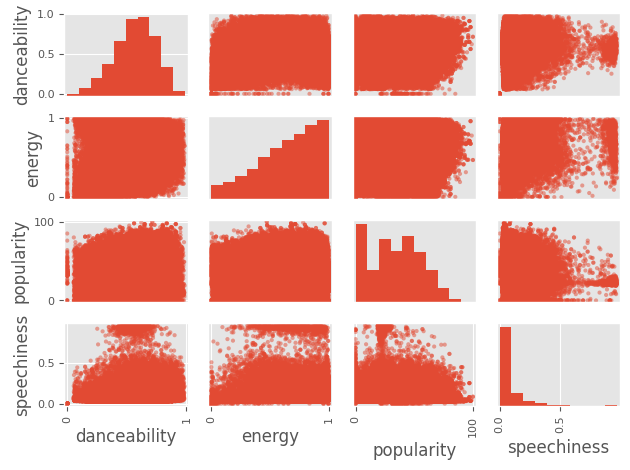

In [9]:
pd.plotting.scatter_matrix(df[['danceability','energy','popularity','speechiness']])
plt.tight_layout();

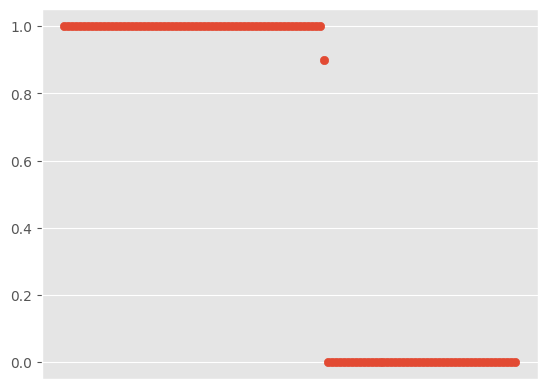

In [10]:
# Look for class imbalance across genres
genre_TracksPer1000 = df.groupby('genre').count().track_name / 1000

fig, ax = plt.subplots()
ax.axes.xaxis.set_ticks([])

ax.scatter(genre_TracksPer1000.index, genre_TracksPer1000.values)

In [11]:
genre_TracksPer1000[genre_TracksPer1000 > .8]

genre
acoustic       1.0
afrobeat       1.0
alt-rock       1.0
alternative    1.0
ambient        1.0
              ... 
j-idol         1.0
j-pop          1.0
j-rock         1.0
jazz           1.0
k-pop          0.9
Name: track_name, Length: 66, dtype: float64

In [12]:
# Creating a dataframe of only popular genres with a large number of data points (>800) to mitigate class imbalance
selected_genres=['acoustic','alt-rock','blues','classical',
                 'country','dance','deep-house','disco',
                 'hardstyle','heavy-metal','k-pop','tango']
subset_df = df[df['genre'].isin(selected_genres)].copy()

In [13]:
subset_df.head()


track_name            artists_name  \
0                      Comedy             Gen Hoshino   
1            Ghost - Acoustic            Ben Woodward   
2              To Begin Again  Ingrid Michaelson;ZAYN   
3  Can't Help Falling In Love            Kina Grannis   
4                     Hold On        Chord Overstreet   

                                          album_name     genre  duration_ms  \
0                                             Comedy  acoustic       230666   
1                                   Ghost (Acoustic)  acoustic       149610   
2                                     To Begin Again  acoustic       210826   
3  Crazy Rich Asians (Original Motion Picture Sou...  acoustic       201933   
4                                            Hold On  acoustic       198853   

   popularity  explicit                track_id  danceability  energy  ...  \
0          73         0  5SuOikwiRyPMVoIQDJUgSV         0.676  0.4610  ...   
1          55         0  4qPNDBW1i3p13qLCt0Ki3A         0.420  0.1660  ...   
2          57         0  1iJBSr7s7jYXzM8EGcbK5b         0.438  0.3590  ...   
3          71         0  6lfxq3CG4xtTiEg7opyCyx         0.266  0.0596  ...   
4          82         0  5vjLSffimiIP26QG5WcN2K         0.618  0.4430  ...   

   loudness  mode  speechiness  acousticness  instrumentalness  liveness  \
0    -6.746     0       0.1430        0.0322          0.000001    0.3580   
1   -17.235     1       0.0763        0.9240          0.000006    0.1010   
2    -9.734     1       0.0557        0.2100          0.000000    0.1170   
3   -18.515     1       0.0363        0.9050          0.000071    0.1320   
4    -9.681     1       0.0526        0.4690          0.000000    0.0829   

   valence    tempo  time_signature  duration_s  
0    0.715   87.917               4       231.0  
1    0.267   77.489               4       150.0  
2    0.120   76.332               4       211.0  
3    0.143  181.740               3       202.0  
4    0.167  119.949               4       199.0  

[5 rows x 21 columns]

In [14]:
subset_df.columns

Index(['track_name', 'artists_name', 'album_name', 'genre', 'duration_ms',
       'popularity', 'explicit', 'track_id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'time_signature', 'duration_s'],
      dtype='object')

In [15]:
audio_features = ['danceability','energy','key','loudness',
                  'mode','speechiness','acousticness',
                  'instrumentalness','liveness','valence',
                  'tempo']

In [16]:
subset_df[audio_features]

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0              0.676  0.4610    1    -6.746     0       0.1430        0.0322   
1              0.420  0.1660    1   -17.235     1       0.0763        0.9240   
2              0.438  0.3590    0    -9.734     1       0.0557        0.2100   
3              0.266  0.0596    0   -18.515     1       0.0363        0.9050   
4              0.618  0.4430    2    -9.681     1       0.0526        0.4690   
...              ...     ...  ...       ...   ...          ...           ...   
108995         0.343  0.0469    4   -22.113     1       0.0441        0.8970   
108996         0.441  0.5570    0    -8.839     1       0.2290        0.5870   
108997         0.481  0.2990    5    -7.951     0       0.0500        0.9590   
108998         0.474  0.4440    2    -8.896     1       0.0544        0.7680   
108999         0.718  0.3470    4    -9.492     0       0.0505        0.8730   

        instrumentalness  liveness  valence    tempo  
0               0.000001    0.3580    0.715   87.917  
1               0.000006    0.1010    0.267   77.489  
2               0.000000    0.1170    0.120   76.332  
3               0.000071    0.1320    0.143  181.740  
4               0.000000    0.0829    0.167  119.949  
...                  ...       ...      ...      ...  
108995          0.071600    0.1780    0.167   97.274  
108996          0.000000    0.9750    0.445  106.146  
108997          0.000006    0.1080    0.566  125.092  
108998          0.000000    0.1270    0.441  103.051  
108999          0.729000    0.1240    0.815  110.649  

[12000 rows x 11 columns]

<Axes: >

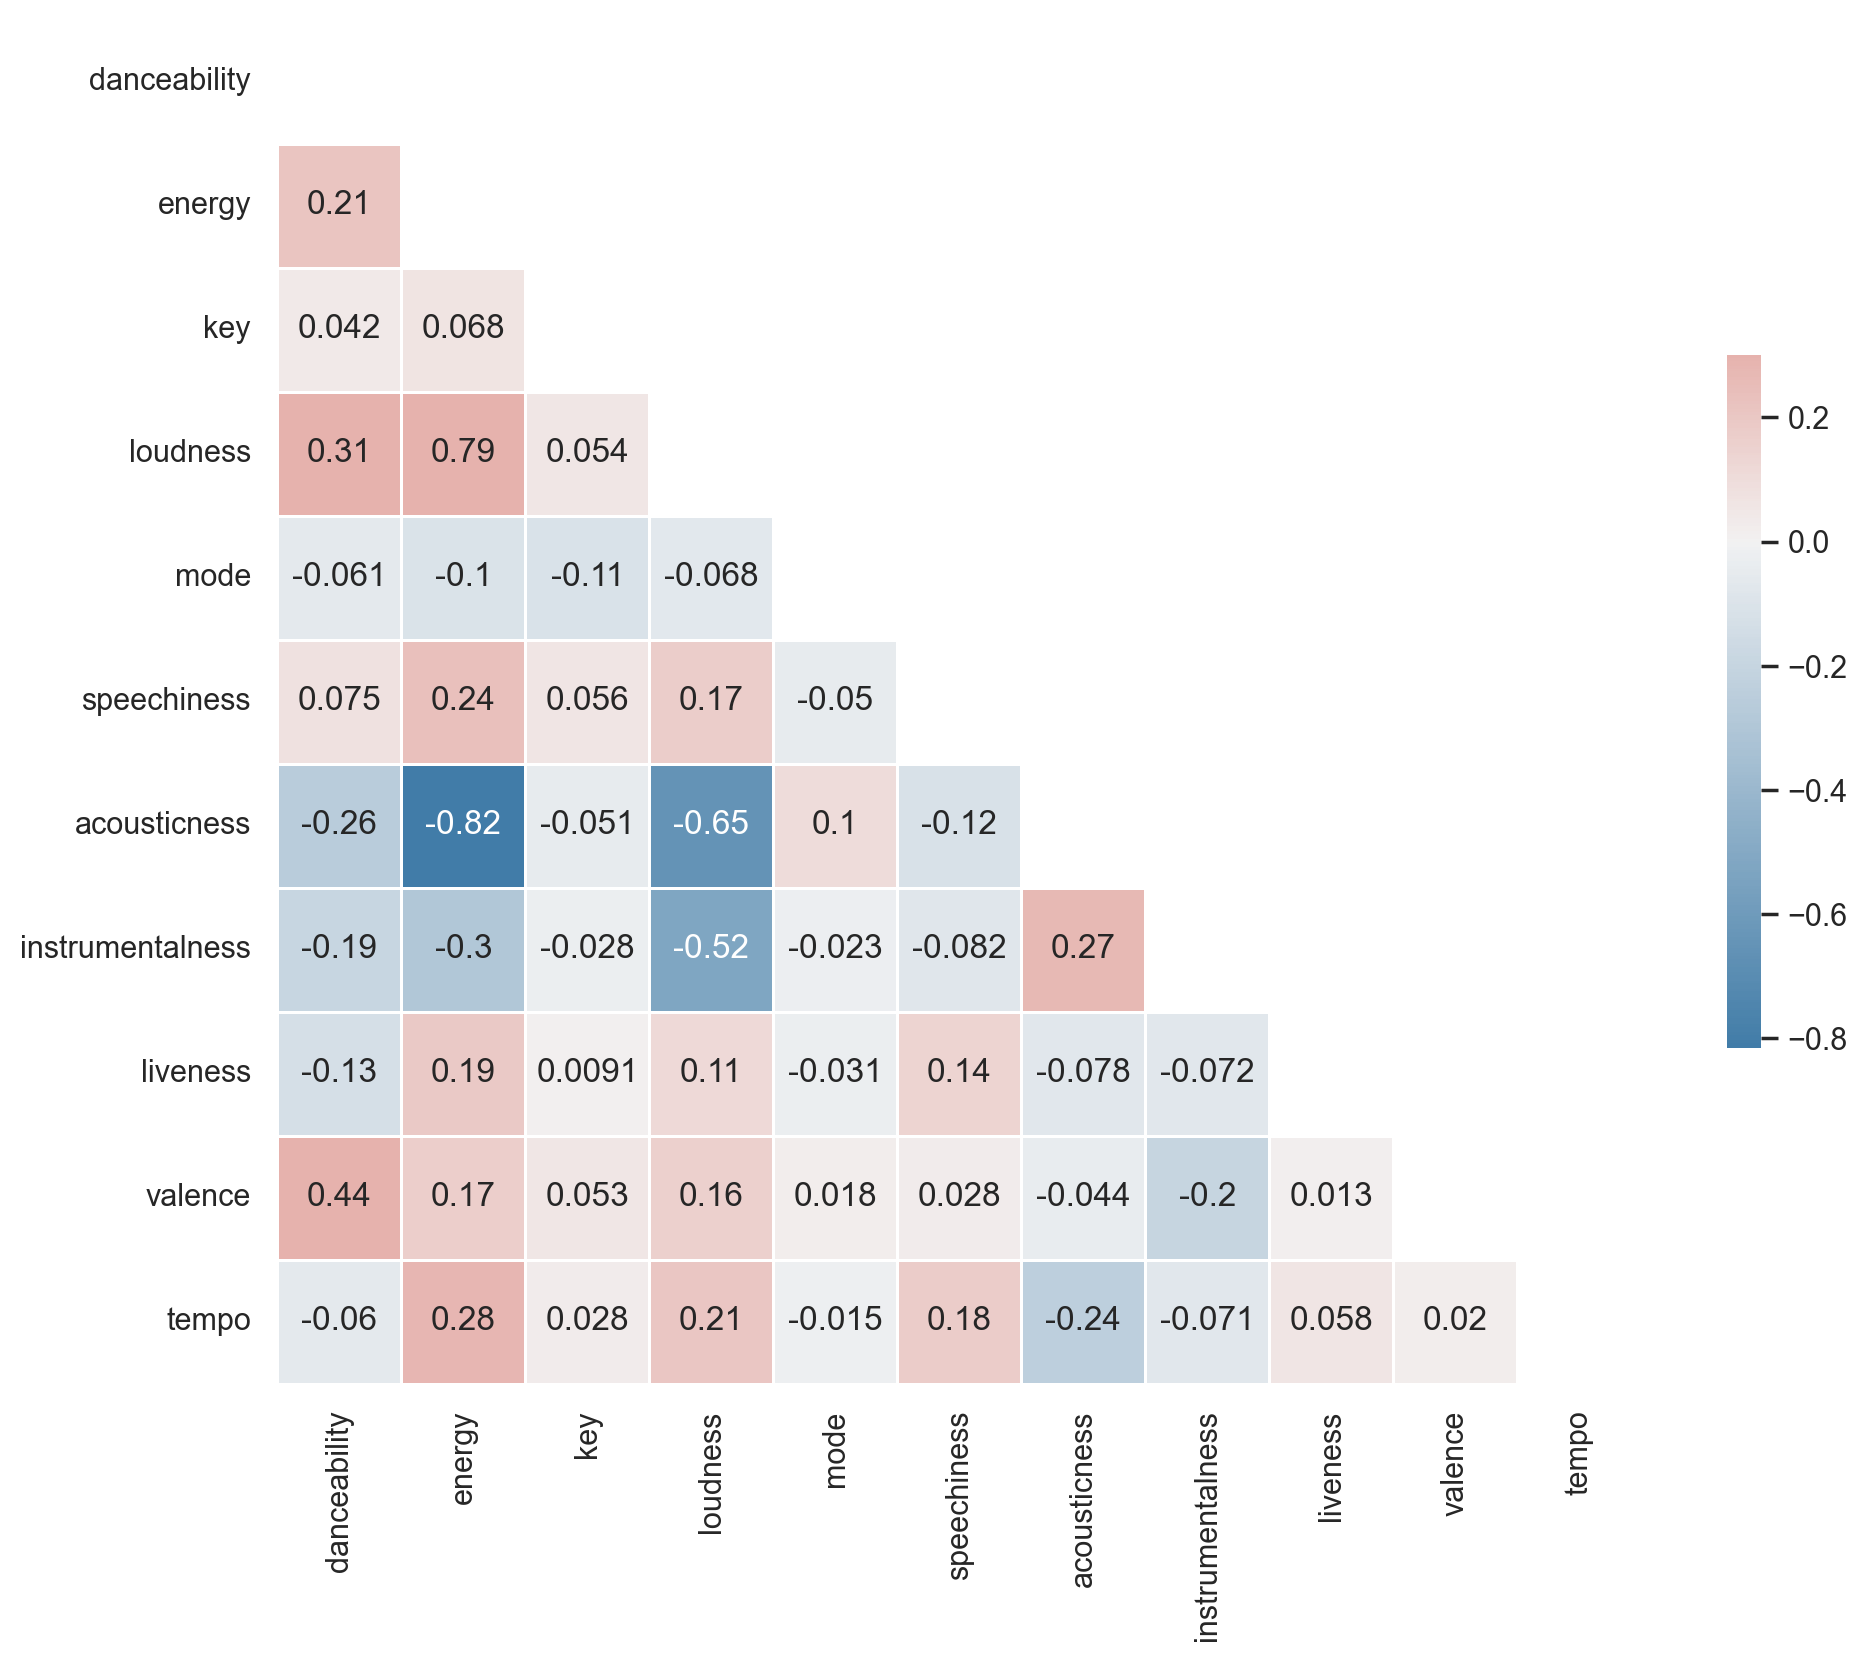

In [17]:
sns.set_theme(style="white")

# Compute the correlation matrix
corr = subset_df[audio_features].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9), dpi=200)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 15, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, annot=True, cbar_kws={"shrink": .5})



In [18]:
subset_df.groupby('genre')


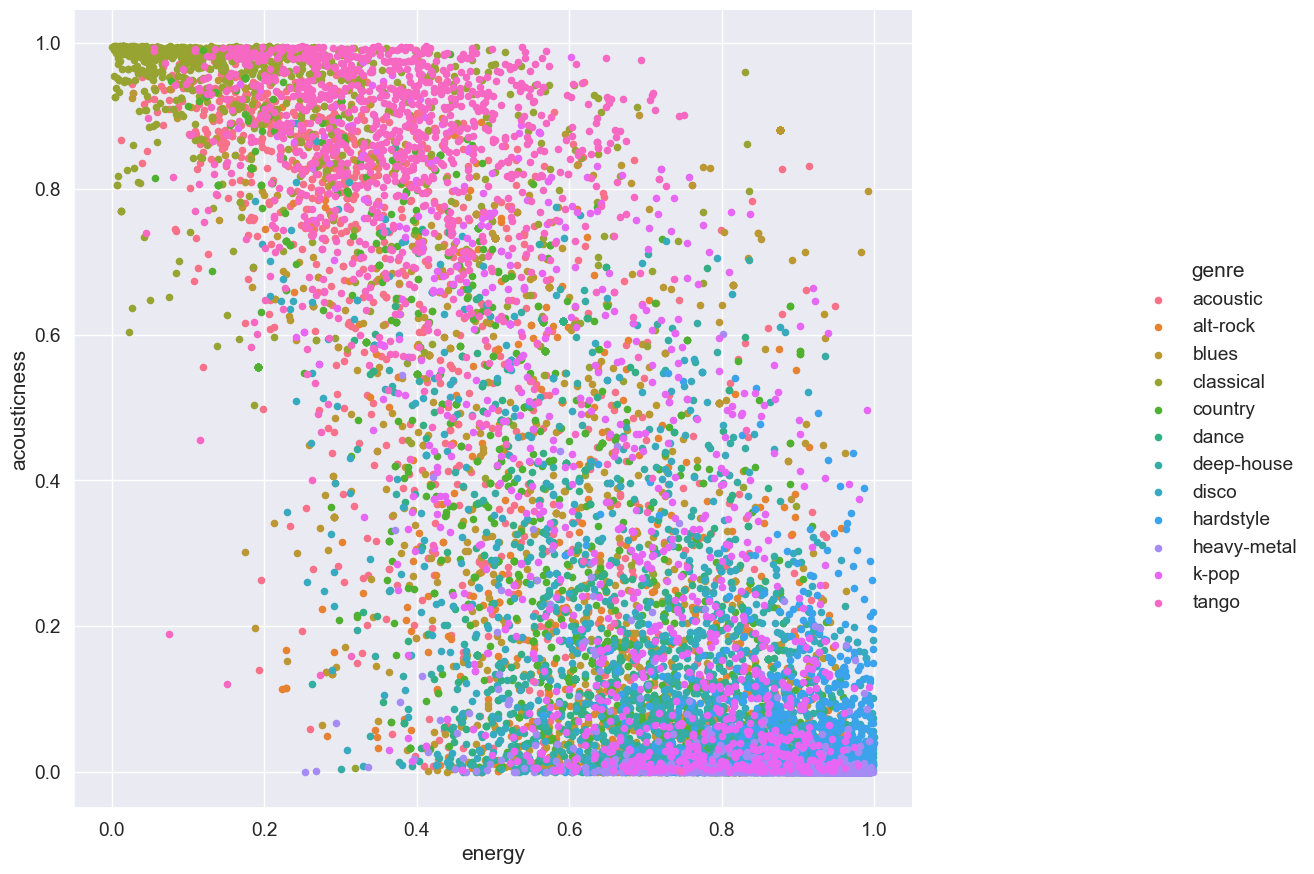

In [19]:
# Acousticness vs Energy
sns.set(font_scale=1.25)

sns.lmplot(x='energy',y='acousticness', data=subset_df, hue='genre', fit_reg=False, scatter_kws={"s": 20, "alpha": 1})
fig = plt.gcf()
fig.set_size_inches(15, 10)
plt.rcParams['figure.dpi'] = 200

plt.show()

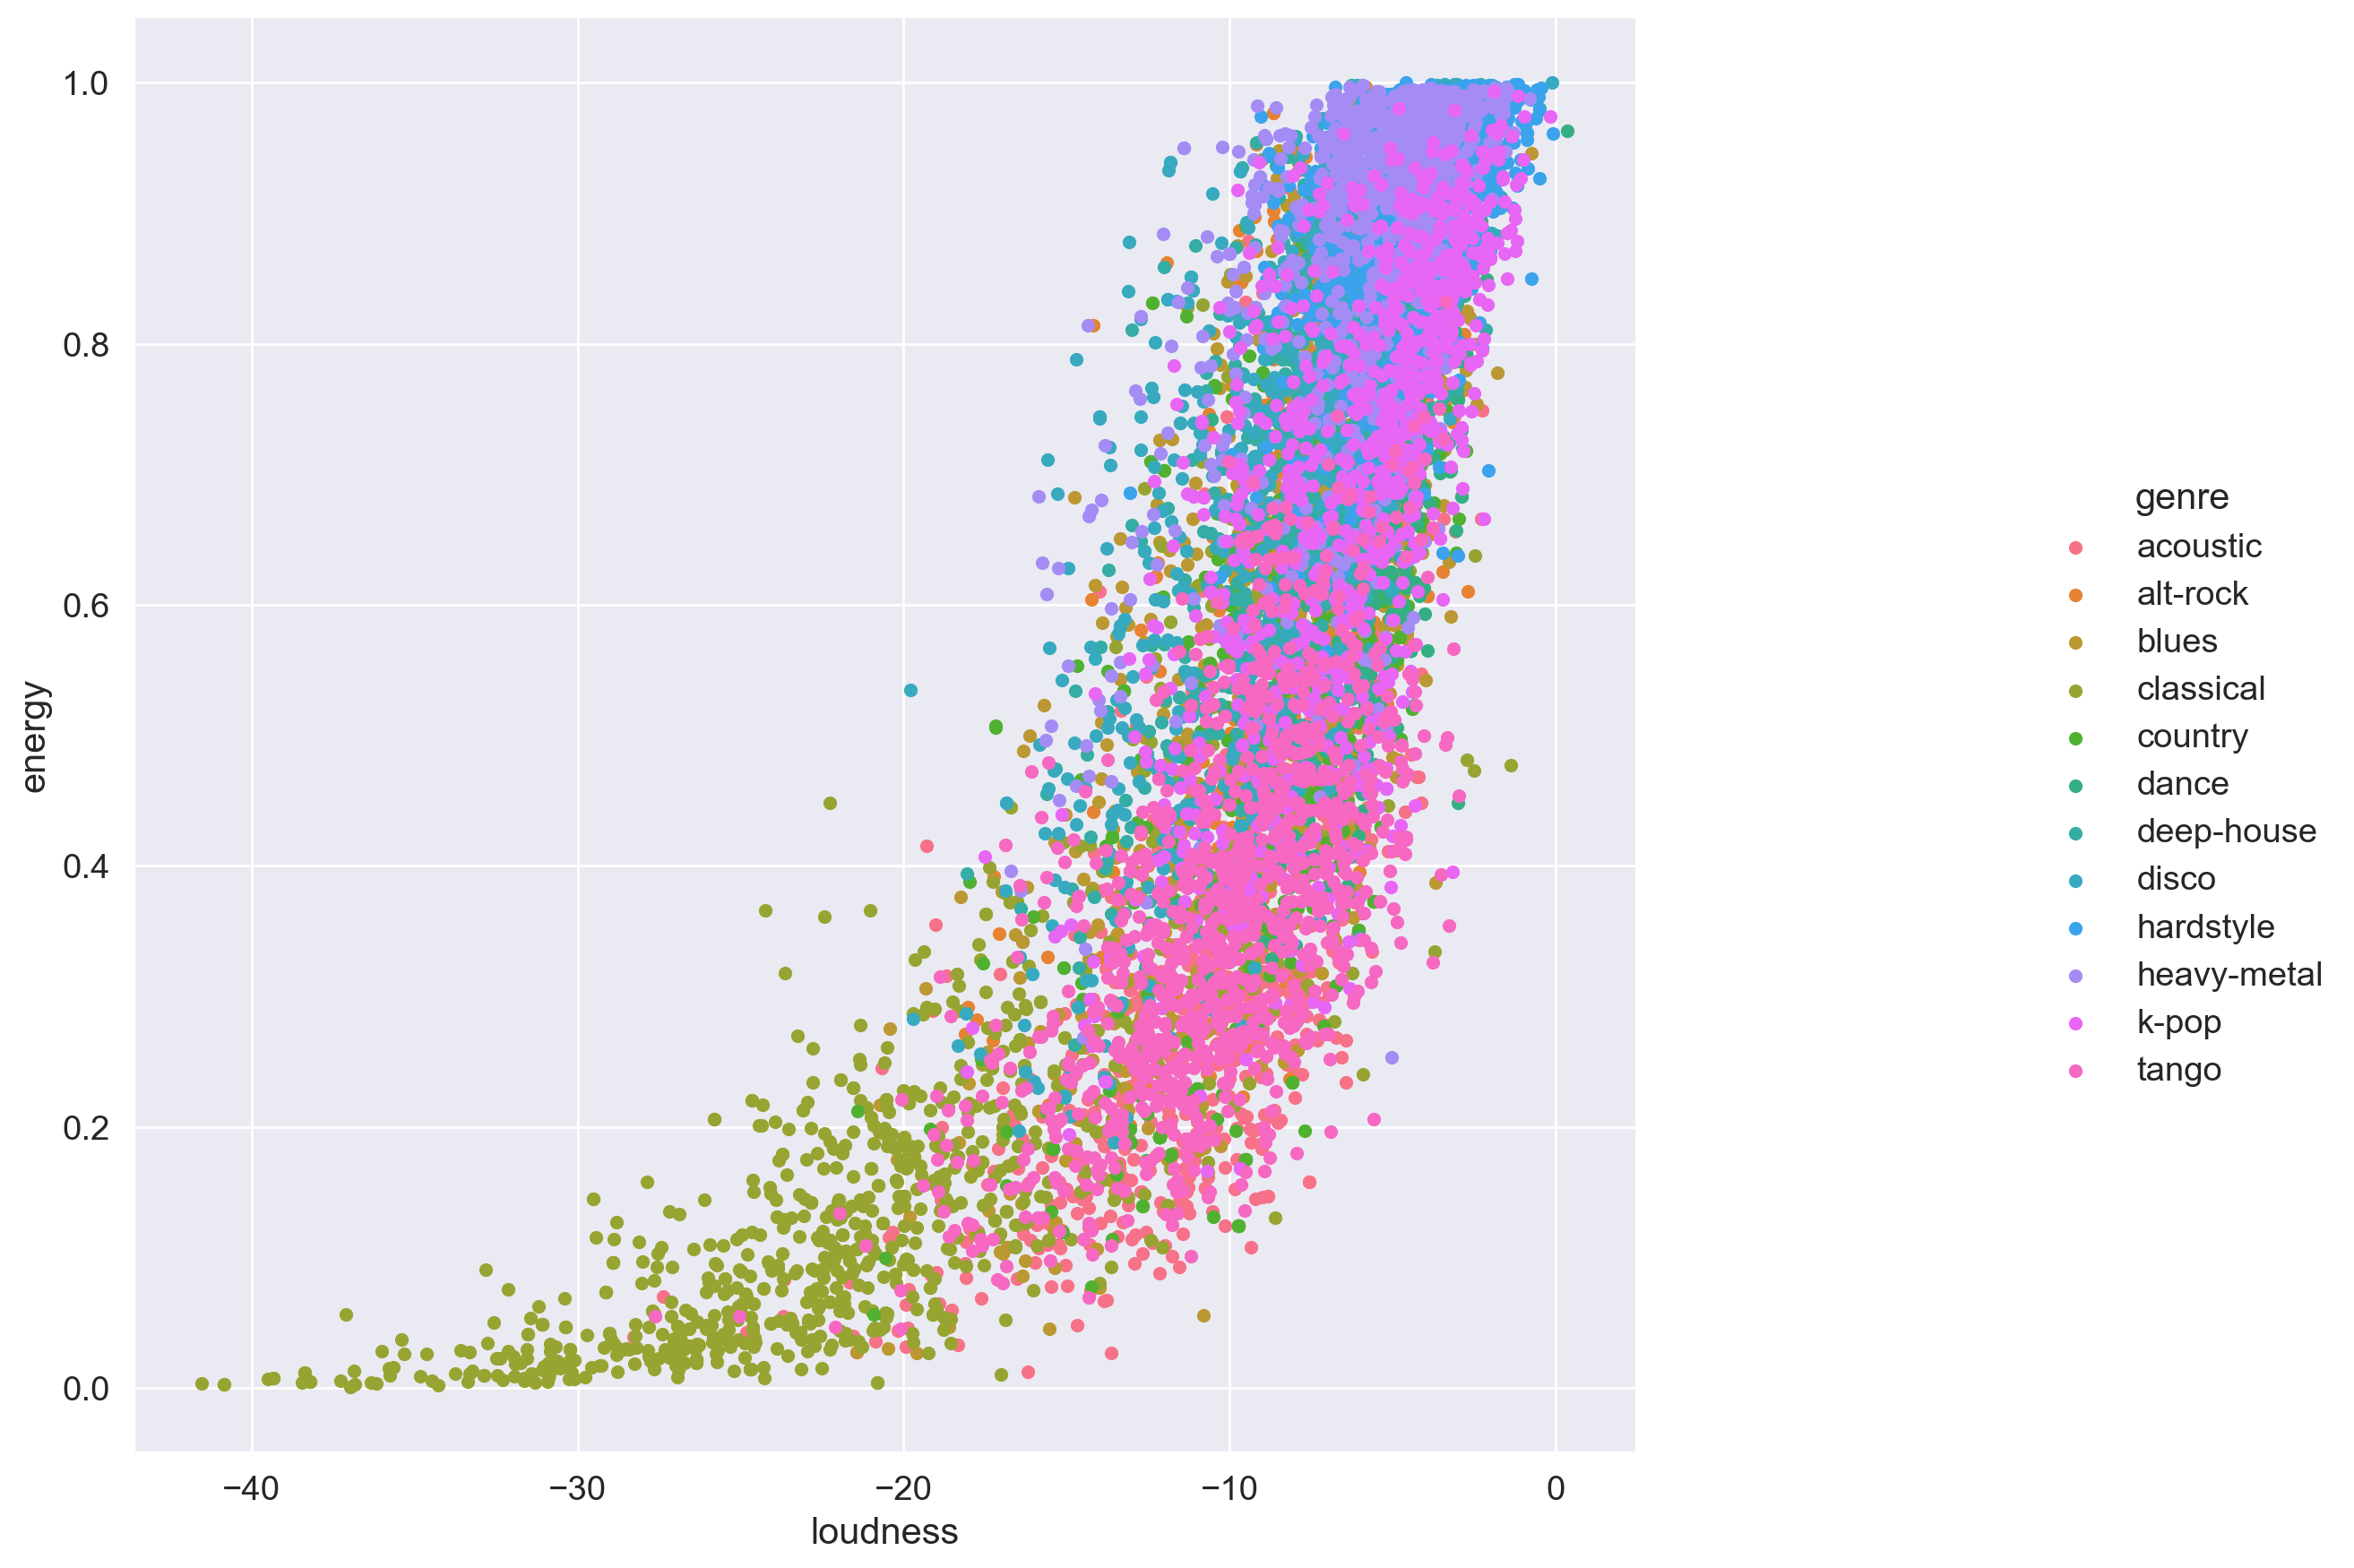

In [20]:
# Loudness vs Energy
sns.set(font_scale=1.25)

sns.lmplot(x='loudness',y='energy', data=subset_df, hue='genre', fit_reg=False, scatter_kws={"s": 20, "alpha": 1})
fig = plt.gcf()

fig.set_size_inches(15, 10)
plt.rcParams['figure.dpi'] = 200

plt.show()

In [21]:
import matplotlib.pyplot as plt

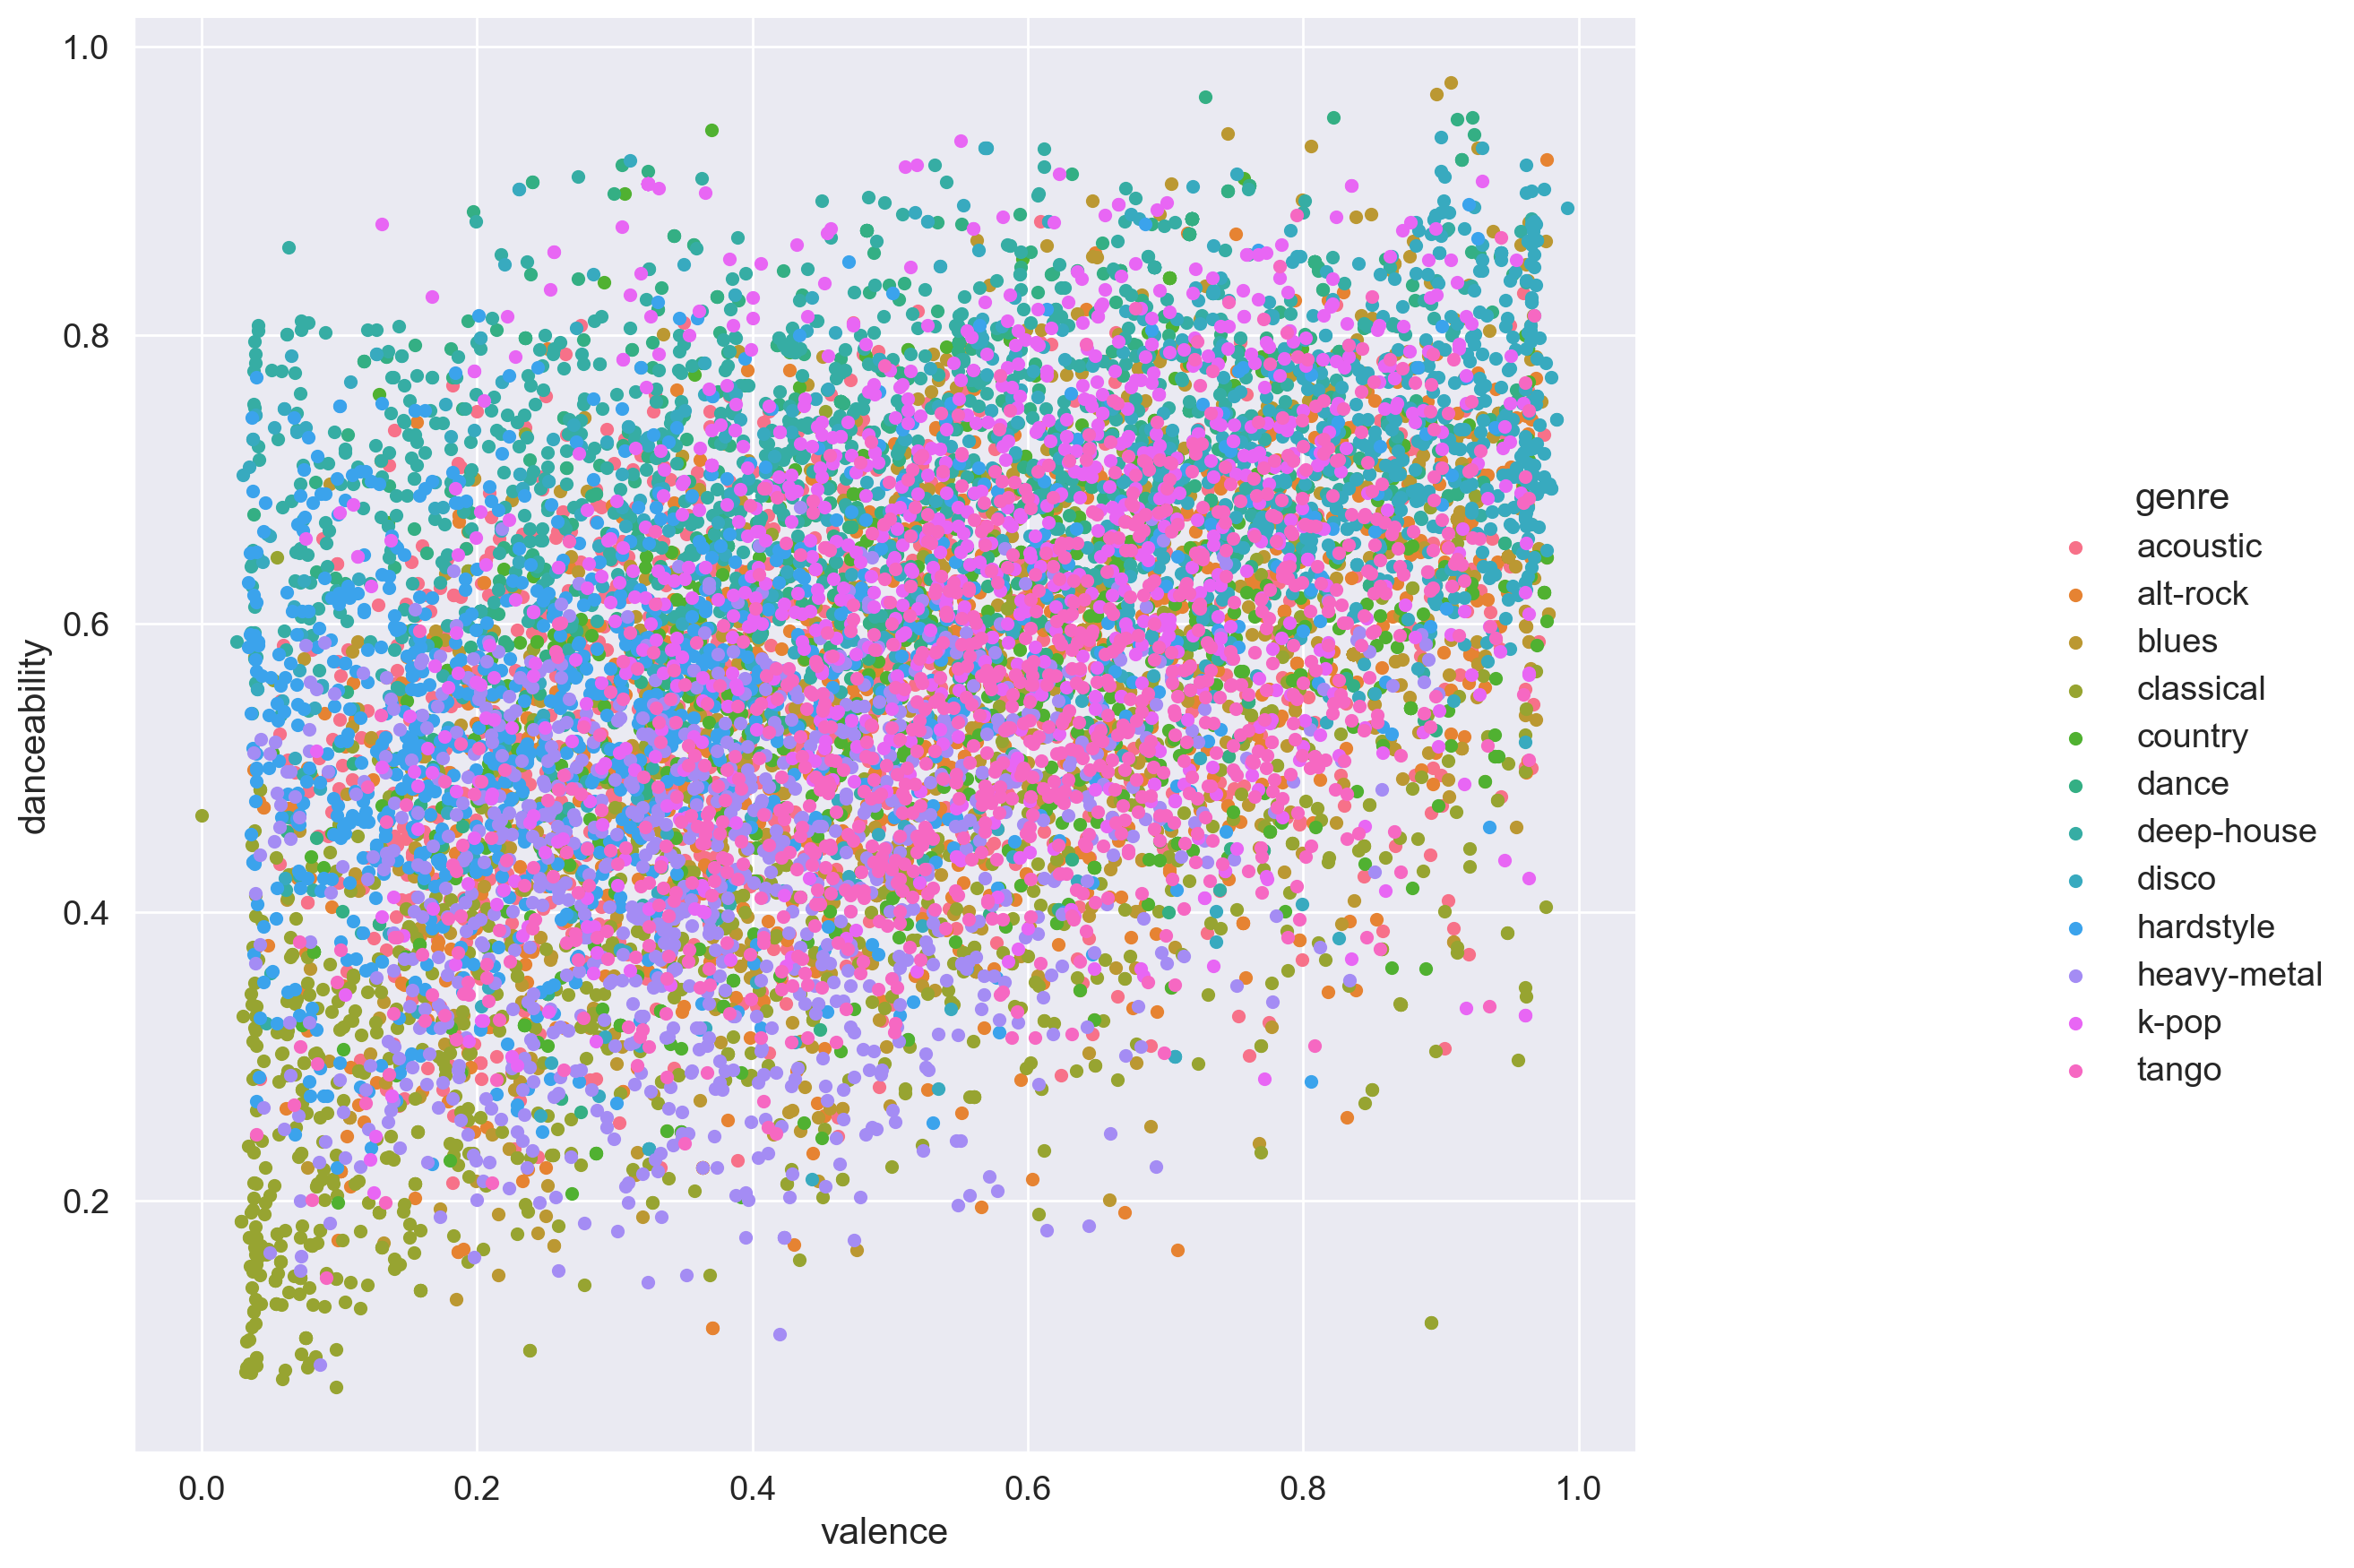

In [22]:
# Valence vs Danceability 
sns.set(font_scale=1.25)

sns.lmplot(x='valence',y='danceability', data=subset_df, hue='genre', fit_reg=False, scatter_kws={"s": 20, "alpha": 1})
fig = plt.gcf()

fig.set_size_inches(15, 10)
plt.rcParams['figure.dpi'] = 200

plt.show()

In [23]:
# Remove non-numeric or unnecessary rows
subset_df.drop(['track_id','duration_ms','track_name','artists_name','album_name'], axis=1, inplace=True)
full_df = df.drop(['track_id','duration_ms','track_name','artists_name','album_name'], axis=1)

In [24]:
subset_df

genre  popularity  explicit  danceability  energy  key  loudness  \
0       acoustic          73         0         0.676  0.4610    1    -6.746   
1       acoustic          55         0         0.420  0.1660    1   -17.235   
2       acoustic          57         0         0.438  0.3590    0    -9.734   
3       acoustic          71         0         0.266  0.0596    0   -18.515   
4       acoustic          82         0         0.618  0.4430    2    -9.681   
...          ...         ...       ...           ...     ...  ...       ...   
108995     tango          16         0         0.343  0.0469    4   -22.113   
108996     tango          16         0         0.441  0.5570    0    -8.839   
108997     tango          16         0         0.481  0.2990    5    -7.951   
108998     tango          17         0         0.474  0.4440    2    -8.896   
108999     tango          16         0         0.718  0.3470    4    -9.492   

        mode  speechiness  acousticness  instrumentalness  liveness  valence  \
0          0       0.1430        0.0322          0.000001    0.3580    0.715   
1          1       0.0763        0.9240          0.000006    0.1010    0.267   
2          1       0.0557        0.2100          0.000000    0.1170    0.120   
3          1       0.0363        0.9050          0.000071    0.1320    0.143   
4          1       0.0526        0.4690          0.000000    0.0829    0.167   
...      ...          ...           ...               ...       ...      ...   
108995     1       0.0441        0.8970          0.071600    0.1780    0.167   
108996     1       0.2290        0.5870          0.000000    0.9750    0.445   
108997     0       0.0500        0.9590          0.000006    0.1080    0.566   
108998     1       0.0544        0.7680          0.000000    0.1270    0.441   
108999     0       0.0505        0.8730          0.729000    0.1240    0.815   

          tempo  time_signature  duration_s  
0        87.917               4       231.0  
1        77.489               4       150.0  
2        76.332               4       211.0  
3       181.740               3       202.0  
4       119.949               4       199.0  
...         ...             ...         ...  
108995   97.274               4       252.0  
108996  106.146               3       170.0  
108997  125.092               3       165.0  
108998  103.051               4       185.0  
108999  110.649               4       157.0  

[12000 rows x 16 columns]

# Machine Learning

In [25]:
# Initialize Features and Target
X = subset_df.copy()
y = X.pop('genre')

Xf = full_df.copy()
yf = Xf.pop('genre')

# Establish Train/Validation-Test split
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1, stratify=y)
Xf_train_val, Xf_test, yf_train_val, yf_test = train_test_split(Xf, yf, test_size=0.1, stratify=yf)

In [26]:
# Traditional train-test split
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2, stratify=y_train_val)
Xf_train, Xf_val, yf_train, yf_val = train_test_split(Xf_train_val, yf_train_val, test_size=0.2, stratify=yf_train_val)

Class= acoustic, n= 1000 (0.88%)
Class= afrobeat, n= 1000 (0.88%)
Class= alt-rock, n= 1000 (0.88%)
Class= alternative, n= 1000 (0.88%)
Class= ambient, n= 1000 (0.88%)
Class= anime, n= 1000 (0.88%)
Class= black-metal, n= 1000 (0.88%)
Class= bluegrass, n= 1000 (0.88%)
Class= blues, n= 1000 (0.88%)
Class= brazil, n= 1000 (0.88%)
Class= breakbeat, n= 1000 (0.88%)
Class= british, n= 1000 (0.88%)
Class= cantopop, n= 1000 (0.88%)
Class= chicago-house, n= 1000 (0.88%)
Class= children, n= 1000 (0.88%)
Class= chill, n= 1000 (0.88%)
Class= classical, n= 1000 (0.88%)
Class= club, n= 1000 (0.88%)
Class= comedy, n= 1000 (0.88%)
Class= country, n= 1000 (0.88%)
Class= dance, n= 1000 (0.88%)
Class= dancehall, n= 1000 (0.88%)
Class= death-metal, n= 1000 (0.88%)
Class= deep-house, n= 1000 (0.88%)
Class= detroit-techno, n= 1000 (0.88%)
Class= disco, n= 1000 (0.88%)
Class= disney, n= 1000 (0.88%)
Class= drum-and-bass, n= 1000 (0.88%)
Class= dub, n= 1000 (0.88%)
Class= dubstep, n= 1000 (0.88%)
Class= edm, n

<BarContainer object of 114 artists>

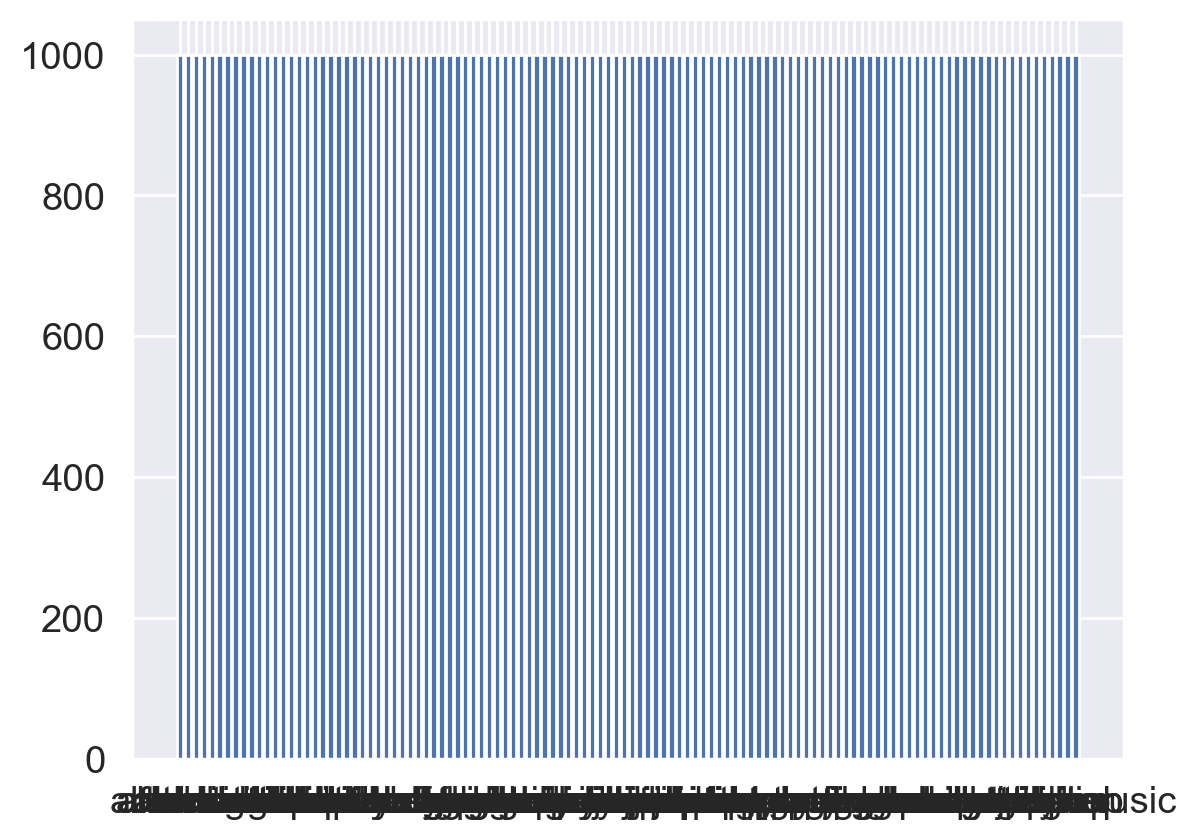

In [27]:
# view class imbalance in full dataset
counter = Counter(yf)
for k,v in counter.items():
    per = v / len(yf) * 100
    print(f'Class= {k}, n= {v} ({per:.2f}%)')
    
fig, ax = plt.subplots()
ax.bar(counter.keys(), counter.values())

# Dummy Classifier

In [28]:
# Dummy Classifier
dummy = DummyClassifier()
dummy.fit(X_train, y_train)
print(dummy.score(X_val, y_val))

dummyf = DummyClassifier()
dummyf.fit(Xf_train, yf_train)
print(dummyf.score(Xf_val, yf_val))

0.08333333333333333
0.008771929824561403


# kNN

In [29]:
# Out of box score
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)
print(knn_clf.score(X_val, y_val))

knn_clf = KNeighborsClassifier()
knn_clf.fit(Xf_train, yf_train)
print(knn_clf.score(Xf_val, yf_val))

0.4981481481481482
0.13031189083820663


In [30]:
# Look at different numbers of nearest neighbors
max_k = 0
max_score = 0
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(X_train, y_train)
    score = classifier.score(X_val, y_val)
    # print(f'k = {k}, accuracy = {score}')
    if score > max_score:
        max_k = k
        max_score = score
        
print(f'best k = {max_k}, accuracy = {max_score}')

best k = 15, accuracy = 0.5101851851851852


In [31]:
# Look at different numbers of nearest neighbors
max_k = 0
max_score = 0
for k in range(1,50):
    classifier = KNeighborsClassifier(n_neighbors=k)
    classifier.fit(Xf_train, yf_train)
    score = classifier.score(Xf_val, yf_val)
    # print(f'k = {k}, accuracy = {score}')
    if score > max_score:
        max_k = k
        max_score = score
        
print(f'best k = {max_k}, accuracy = {max_score}')

best k = 21, accuracy = 0.14610136452241715


In [32]:
def cross_val(X_train, y_train, k=3, n=8):
    '''
    Returns accuracy for stratified k-fold cross validation.
    Stratified K-fold is used since we have many classes and
    we want to preserve some amount of each class in each split.
    '''
    skf = StratifiedKFold(n_splits=k)
    accuracy = np.empty(k)
    
    for i, (train, test) in enumerate(skf.split(X_train, y_train)):
        classifier = KNeighborsClassifier(n_neighbors=n)
        classifier.fit(X_train.iloc[train], y_train.iloc[train])
        accuracy[i] = classifier.score(X_train.iloc[test],y_train.iloc[test])
        
    return np.mean(accuracy)

In [33]:
cross_val(X_train, y_train, k=5)


0.4885416666666666

In [34]:
cross_val(Xf_train, yf_train, k=5, n=36)


0.14372563352826512

In [35]:
cross_val(X_train, y_train, k=10)

0.4965277777777778

In [36]:
cross_val(X_train, y_train, k=20)

0.5008101851851852

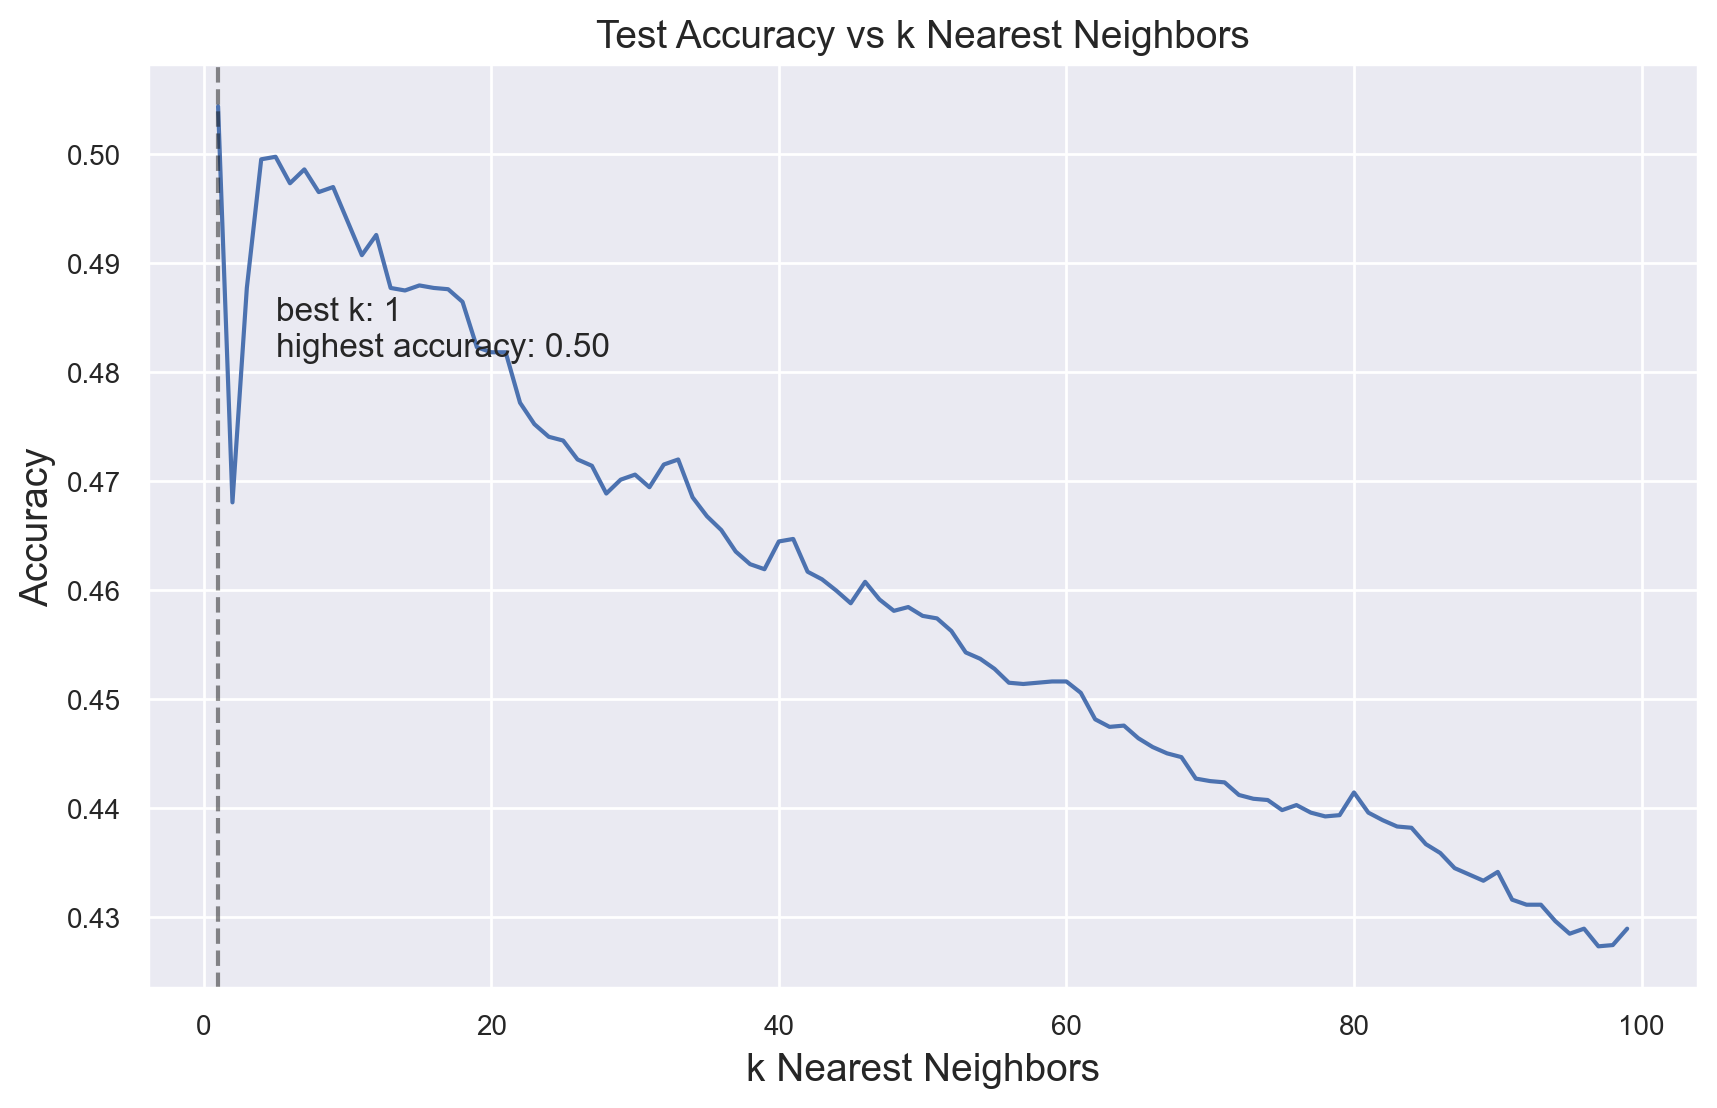

In [37]:
# Plot cross-validation scores for different numbers of
# nearest neighbors with 10 kfolds
cv_scores = []
max_score = 0
max_n = 0
for n in range(1,100):
    cv_score = cross_val(X_train, y_train, k=10, n=n)
    cv_scores.append(cv_score)
    if cv_score > max_score:
        max_score = cv_score
        max_n = n


fig, ax = plt.subplots(figsize=(10,6), dpi=200)    
ax.plot(list(range(1,100)),cv_scores)
ax.axvline(max_n, linestyle='--',c='k',alpha=0.5)
ax.text(max_n+4, max_score-0.023,
        s=f'best k: {max_n}\nhighest accuracy: {max_score:.2f}',
        fontsize=12)
ax.set_xlabel('k Nearest Neighbors', fontsize=14)
ax.set_ylabel('Accuracy', fontsize=14)
ax.tick_params(axis='both',which='major',labelsize=10)
ax.set_title('Test Accuracy vs k Nearest Neighbors', fontsize=14);



Logistic Regression

In [38]:
# Out of Box score
log_clf = LogisticRegression()
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

log_clf = LogisticRegression()
log_clf.fit(Xf_train, yf_train)
score = log_clf.score(Xf_val, yf_val)
print(f'Accuracy = {score}')

c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy = 0.3277777777777778
Accuracy = 0.07524366471734893


c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [39]:
# One versus rest (OVR) classification
log_clf = LogisticRegression(multi_class='ovr',max_iter=10000)
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy = 0.5152777777777777


In [40]:
# Multinomial classification
log_clf = LogisticRegression(multi_class='multinomial',max_iter=10000)
log_clf.fit(X_train, y_train)
score = log_clf.score(X_val, y_val)
print(f'Accuracy = {score}')

c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy = 0.5194444444444445


c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Random Forest

In [41]:
# Out of box score
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf.score(X_val, y_val)

0.7375

In [42]:
rf1 = RandomForestClassifier(n_estimators=500)
rf1.fit(X_train, y_train)
rf1.score(X_val, y_val)

0.7435185185185185

In [43]:
rf2 = RandomForestClassifier(n_estimators=1000)
rf2.fit(X_train, y_train)
rf2.score(X_val, y_val)

0.7444444444444445

In [44]:
rf3 = RandomForestClassifier(n_estimators=750)
rf3.fit(X_train, y_train)
rf3.score(X_val, y_val)

0.7472222222222222

Gradient Boosting

In [45]:
# Out of box score
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
gb.score(X_val, y_val)

0.7152777777777778

In [46]:
subset_df.genre.unique()

array(['acoustic', 'alt-rock', 'blues', 'classical', 'country', 'dance',
       'deep-house', 'disco', 'hardstyle', 'heavy-metal', 'k-pop',
       'tango'], dtype=object)

In [47]:
# Confusion matrix
y_pred = gb.predict(X_val)
confusion_matrix(y_val, y_pred)

array([[106,  12,  10,   4,   6,   1,   5,   8,   3,   6,  14,   5],
       [  5,  89,  11,   0,  26,  15,   8,   5,   0,   0,  20,   1],
       [ 17,  21,  96,   5,   8,   2,   5,  12,   1,   3,   9,   1],
       [  6,   0,   4, 163,   1,   0,   0,   1,   0,   0,   2,   3],
       [ 14,  25,  12,   0, 108,   7,   4,   2,   0,   0,   8,   0],
       [  0,   9,   0,   0,   7, 140,   7,   2,   0,   0,  15,   0],
       [  2,   4,   4,   0,   0,   4, 137,  16,   1,   3,   9,   0],
       [  6,   9,  17,   0,  14,   4,  25,  96,   4,   1,   4,   0],
       [  2,   5,   2,   0,   0,   0,   5,   1, 158,   6,   1,   0],
       [  7,   3,   0,   0,   0,   0,   1,   2,   9, 156,   1,   1],
       [ 18,   6,   8,   0,   2,  12,   8,   2,   0,   0, 124,   0],
       [  1,   0,   1,   3,   0,   0,   0,   2,   0,   1,   0, 172]],
      dtype=int64)

In [48]:
# Confusion matrix
print(gb.score(X_test, y_test))
y_pred_final = gb.predict(X_test)
confusion_matrix(y_test, y_pred_final)

0.7208333333333333


array([[60,  5,  6,  1,  7,  0,  2,  1,  0,  2, 11,  5],
       [ 6, 58,  5,  0, 10,  8,  1,  1,  0,  0, 11,  0],
       [12,  8, 50,  2,  8,  2,  1, 11,  0,  3,  3,  0],
       [ 9,  0,  1, 90,  0,  0,  0,  0,  0,  0,  0,  0],
       [14,  8,  5,  0, 61,  5,  1,  5,  0,  0,  1,  0],
       [ 0,  7,  0,  0,  4, 78,  4,  1,  0,  0,  6,  0],
       [ 2,  1,  3,  0,  0,  3, 78,  7,  0,  0,  6,  0],
       [ 6,  1,  6,  0,  6,  3, 14, 56,  3,  0,  5,  0],
       [ 0,  3,  1,  0,  1,  1,  1,  2, 85,  4,  2,  0],
       [ 0,  2,  2,  0,  0,  0,  0,  1,  8, 87,  0,  0],
       [ 9,  4,  7,  0,  0,  6,  3,  2,  2,  0, 67,  0],
       [ 1,  0,  4,  0,  0,  0,  0,  0,  0,  0,  0, 95]], dtype=int64)

c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  warnings.warn(
c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
c:\Users\vicky\AppData\Local\Programs\Python\Python312\Lib\site-packages

<Axes: >

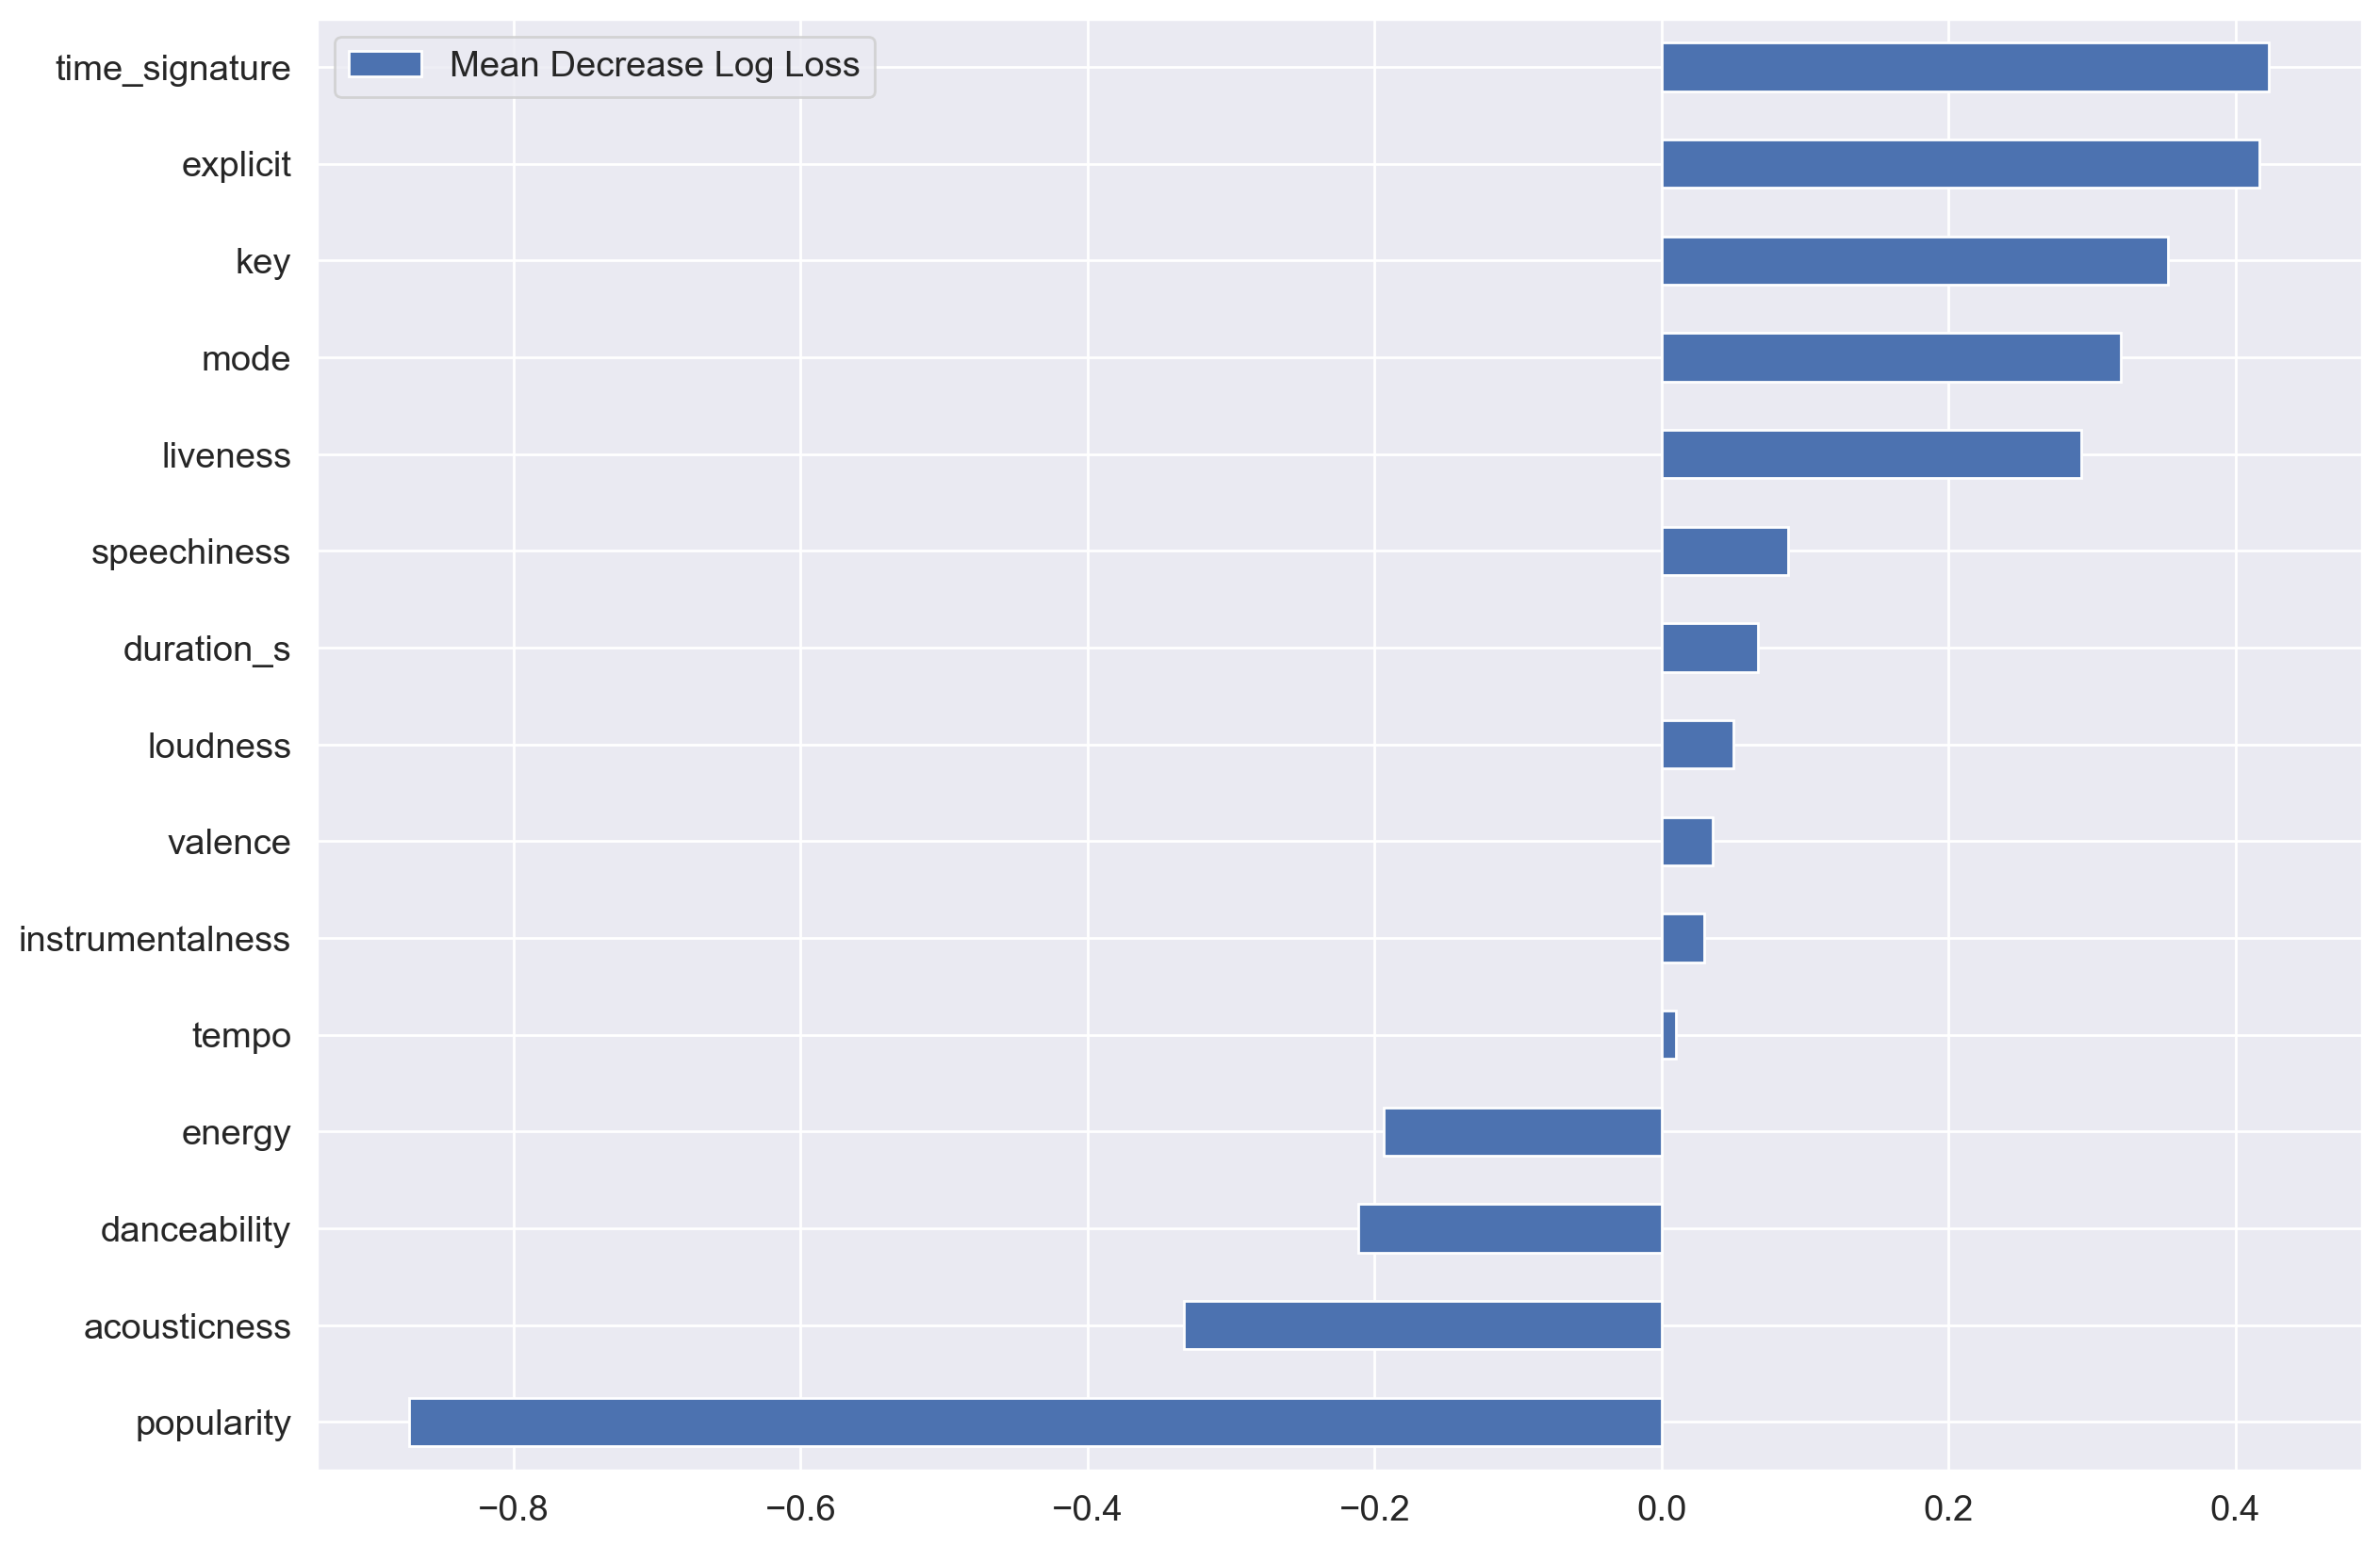

In [49]:
# manual shuffle 
gb_fi = GradientBoostingClassifier()
scores = defaultdict(list)
names = X_train_val.columns.tolist()

# crossvalidate the scores on a number of 
# different random splits of the data
splitter = StratifiedShuffleSplit(100, test_size=.3)
for train_idx, test_idx in splitter.split(X_train_val, y_train_val):
    X_train_fi, X_test_fi = X_train_val.values[train_idx], X_train_val.values[test_idx]
    y_train_fi, y_test_fi = y_train_val.values[train_idx], y_train_val.values[test_idx]
    gb_fi.fit(X_train, y_train)
    acc = log_loss(y_test_fi, gb_fi.predict_proba(X_test_fi))
    for i in range(X_train_val.shape[1]):
        X_t = X_test_fi.copy()
        np.random.shuffle(X_t[:, i])
        shuff_acc = log_loss(y_test_fi, rf.predict_proba(X_t))
        scores[names[i]].append((acc-shuff_acc)/acc)
score_series = pd.DataFrame(scores).mean()
scores = pd.DataFrame({'Mean Decrease Log Loss' : score_series})
scores.sort_values(by='Mean Decrease Log Loss').plot(kind='barh', figsize = (14,10))

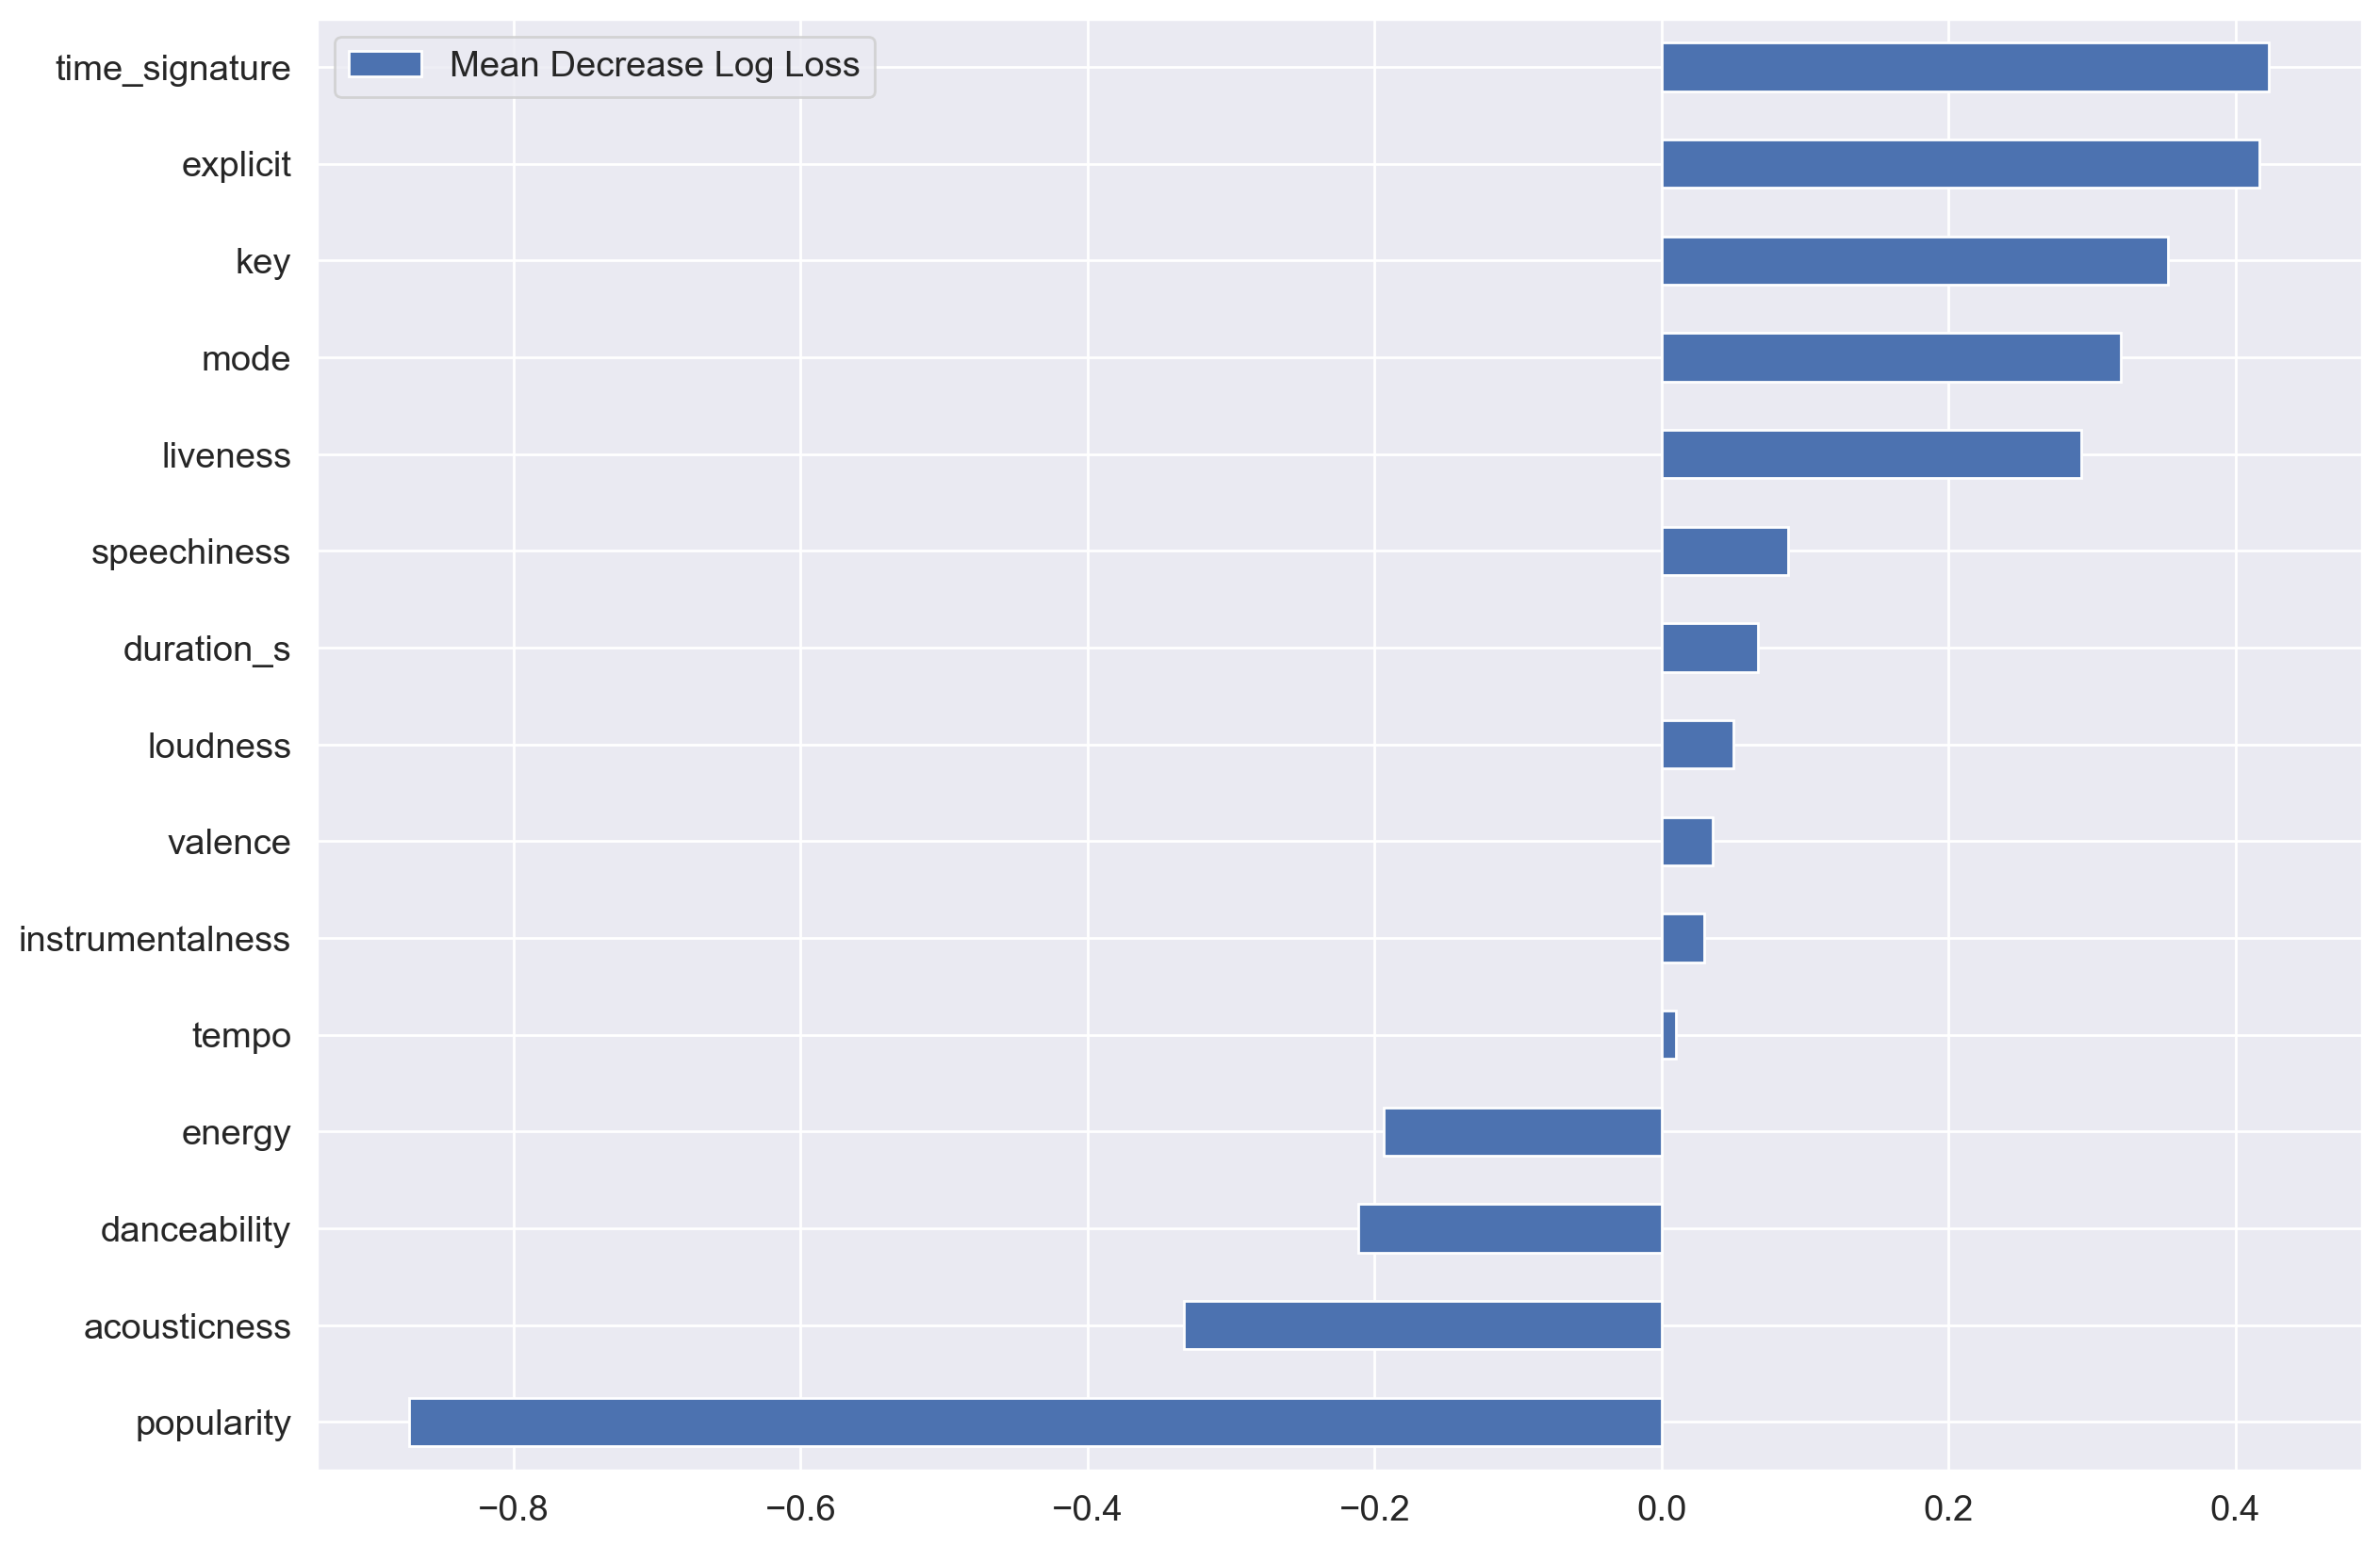

In [52]:
scores.sort_values(by='Mean Decrease Log Loss').plot(kind='barh', figsize = (14,10))
ax = plt.gcf()
plt.rcParams['figure.dpi'] = 200



In [53]:
gb = GradientBoostingClassifier(n_estimators=200,learning_rate=.1)
gb.fit(X_train,y_train)
cross_val_score(estimator=gb,X=X_train_val,y=y_train_val,scoring='accuracy',cv=5)

array([0.73101852, 0.73935185, 0.73055556, 0.7375    , 0.73888889])

In [57]:
gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_features='sqrt', max_depth=3, random_state=0)
gb_clf.fit(X_train, y_train)

print("Learning rate: ", gb_clf.learning_rate)
print("Number of estimators: ", gb_clf.n_estimators)
print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
print("Accuracy score (validation): {0:.3f}\n".format(gb_clf.score(X_val, y_val)))


Learning rate:  0.1
Number of estimators:  100
Accuracy score (training): 0.817
Accuracy score (validation): 0.709



In [58]:
max_depths = np.arange(1,10).tolist()
estimator_lst = [20, 50, 100, 200, 500]

best_depth, best_estimator = 0, 0

for n_estimators in estimator_lst:
    for depth in max_depths:
        gb_clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=0.1, max_features='sqrt', max_depth=depth, random_state=0)
        gb_clf.fit(X_train, y_train)

        # print("Max Depth: ", depth)
        # print("Number of estimators: ", gb_clf.n_estimators)
        # print("Accuracy score (training): {0:.3f}".format(gb_clf.score(X_train, y_train)))
        # print("Accuracy score (validation): {0:.3f}\n".format(gb_clf.score(X_val, y_val)))

In [59]:
tuned_parameters = {'n_estimators': [10, 50, 100, 500, 1000],
                    'max_features': [1,2,3,4],
                    'max_depth':[1,3,5,7]}

print("# Tuning hyper-parameters for %s" % score)
print()

clf = GridSearchCV(GradientBoostingClassifier(), tuned_parameters, scoring='accuracy',n_jobs=-1)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)
print()
print("Grid scores on development set:")
print()
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']

for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

print()

print("Detailed classification report:")
print()
print("The model is trained on the full development set.")
print("The scores are computed on the full evaluation set.")
print()
y_true, y_pred = y_val, clf.predict(X_val)
print(classification_report(y_true, y_pred))
print()

# Tuning hyper-parameters for 0.5194444444444445

Best parameters set found on development set:

{'max_depth': 7, 'max_features': 2, 'n_estimators': 500}

Grid scores on development set:

0.387 (+/-0.086) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 10}
0.536 (+/-0.021) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 50}
0.580 (+/-0.015) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 100}
0.671 (+/-0.022) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 500}
0.690 (+/-0.025) for {'max_depth': 1, 'max_features': 1, 'n_estimators': 1000}
0.450 (+/-0.014) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 10}
0.572 (+/-0.018) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 50}
0.614 (+/-0.015) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 100}
0.689 (+/-0.022) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 500}
0.699 (+/-0.021) for {'max_depth': 1, 'max_features': 2, 'n_estimators': 1000}
0.470 (+/-0.027) for {'max_depth':

In [60]:
gb_final= GradientBoostingClassifier(n_estimators=2500, learning_rate=0.01)
gb_final.fit(X_train, y_train)
gb_final.score(X_val, y_val)

0.7268518518518519